## Solo Queue Modeling

Using a dataset from LoL's Diamond I to Masters level soloq game stats at 10 minutes that Andre has engineered some features for, I begin my modeling process below.

In [1]:
import pandas as pd
import numpy as np

from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.svm import SVC
from sklearn.compose import ColumnTransformer
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score, roc_auc_score, plot_confusion_matrix
from sklearn.linear_model import LogisticRegression

# imports for visualizations
import matplotlib.pyplot as plt
import matplotlib.pylab as pl
import xgboost

# I'm importing a functions.py file that I created so I can reuse a scoring function in the file
import sys
if not 'Notebooks/Individual/Jake' in sys.path:
    sys.path.append('Notebooks/Individual/jake')
from functions import ScoreModel, FeatureImp #featureimp is throwing errors about dfs not being defined

# the below lines are to play an alert sound for when the notebook finishes running
import IPython
sound_file = '../../../archive/sounds/puzzle_solved_jingle.wav'

# I wanted to be able to see all the columns when using .head()
pd.set_option('display.max_columns', None)

#### Reading in Andre's dataset and doing initial checks to make sure everything is there

In [2]:
df = pd.read_csv("../../../archive/with_rates.csv")

df.head()

gameId  blueWins  blueWardsPlaced  blueWardsDestroyed  blueFirstBlood  \
0  4519157822         0               28                   2               1   
1  4523371949         0               12                   1               0   
2  4521474530         0               15                   0               0   
3  4524384067         0               43                   1               0   
4  4436033771         0               75                   4               0   

   blueKills  blueAssists  blueDragons  blueHeralds  blueTowersDestroyed  \
0          9           11            0            0                    0   
1          5            5            0            0                    0   
2          7            4            1            0                    0   
3          4            5            0            1                    0   
4          6            6            0            0                    0   

   blueAvgLevel  blueTotalExperience  blueTotalJungleMinionsKilled  \
0           6.6                17039                            36   
1           6.6                16265                            43   
2           6.4                16221                            46   
3           7.0                17954                            55   
4           7.0                18543                            57   

   blueGoldDiff  blueExperienceDiff  blueCSPerMin  blueGoldPerMin  \
0           643                  -8          19.5          1721.0   
1         -2908               -1173          17.4          1471.2   
2         -1172               -1033          18.6          1611.3   
3         -1321                  -7          20.1          1515.7   
4         -1004                 230          21.0          1640.0   

   redWardsPlaced  redWardsDestroyed  redKills  redAssists  redDragons  \
0              15                  6         6           8           0   
1              12                  1         5           2           1   
2              15                  3        11          14           0   
3              15                  2         5          10           0   
4              17                  2         6           7           1   

   redHeralds  redTowersDestroyed  redAvgLevel  redTotalExperience  \
0           0                   0          6.8               17047   
1           1                   1          6.8               17438   
2           0                   0          6.8               17254   
3           0                   0          7.0               17961   
4           0                   0          7.0               18313   

   redTotalJungleMinionsKilled  redCSPerMin  redGoldPerMin  \
0                           55         19.7         1656.7   
1                           52         24.0         1762.0   
2                           28         20.3         1728.5   
3                           47         23.5         1647.8   
4                           67         22.5         1740.4   

                                          champions                blueChamps  \
0      [111, 91, 236, 76, 54, 26, 235, 82, 421, 69]    [111, 91, 236, 76, 54]   
1      [4, 350, 75, 145, 875, 110, 59, 53, 134, 39]    [4, 350, 75, 145, 875]   
2    [421, 84, 236, 43, 45, 145, 154, 92, 134, 223]    [421, 84, 236, 43, 45]   
3  [64, 134, 516, 432, 429, 110, 412, 58, 245, 238]  [64, 134, 516, 432, 429]   
4     [101, 266, 245, 143, 21, 51, 86, 69, 235, 32]  [101, 266, 245, 143, 21]   

                  redChamps  bluePredWinrate  redPredWinrate  blueAvgPickrate  \
0    [26, 235, 82, 421, 69]         0.489394        0.509859         0.086790   
1    [110, 59, 53, 134, 39]         0.492787        0.492763         0.124203   
2  [145, 154, 92, 134, 223]         0.489751        0.498580         0.086608   
3  [110, 412, 58, 245, 238]         0.501475        0.508625         0.162425   
4     [51, 86, 69, 235, 32]         0.494971        0.511632         0.122280   

   redAvgPickrate  


In [3]:
df.describe()

gameId     blueWins  blueWardsPlaced  blueWardsDestroyed  \
count  9.879000e+03  9879.000000      9879.000000         9879.000000   
mean   4.500084e+09     0.499038        22.288288            2.824881   
std    2.757328e+07     0.500024        18.019177            2.174998   
min    4.295358e+09     0.000000         5.000000            0.000000   
25%    4.483301e+09     0.000000        14.000000            1.000000   
50%    4.510920e+09     0.000000        16.000000            3.000000   
75%    4.521733e+09     1.000000        20.000000            4.000000   
max    4.527991e+09     1.000000       250.000000           27.000000   

       blueFirstBlood    blueKills  blueAssists  blueDragons  blueHeralds  \
count     9879.000000  9879.000000  9879.000000  9879.000000  9879.000000   
mean         0.504808     6.183925     6.645106     0.361980     0.187974   
std          0.500002     3.011028     4.064520     0.480597     0.390712   
min          0.000000     0.000000     0.000000     0.000000     0.000000   
25%          0.000000     4.000000     4.000000     0.000000     0.000000   
50%          1.000000     6.000000     6.000000     0.000000     0.000000   
75%          1.000000     8.000000     9.000000     1.000000     0.000000   
max          1.000000    22.000000    29.000000     1.000000     1.000000   

       blueTowersDestroyed  blueAvgLevel  blueTotalExperience  \
count          9879.000000   9879.000000          9879.000000   
mean              0.051422      6.916004         17928.110133   
std               0.244369      0.305146          1200.523764   
min               0.000000      4.600000         10098.000000   
25%               0.000000      6.800000         17168.000000   
50%               0.000000      7.000000         17951.000000   
75%               0.000000      7.200000         18724.000000   
max               4.000000      8.000000         22224.000000   

       blueTotalJungleMinionsKilled  blueGoldDiff  blueExperienceDiff  \
count                   9879.000000   9879.000000         9879.000000   
mean                      50.509667     14.414111          -33.620306   
std                        9.898282   2453.349179         1920.370438   
min                        0.000000 -10830.000000        -9333.000000   
25%                       44.000000  -1585.500000        -1290.500000   
50%                       50.000000     14.000000          -28.000000   
75%                       56.000000   1596.000000         1212.000000   
max                       92.000000  11467.000000         8348.000000   

       blueCSPerMin  blueGoldPerMin  redWardsPlaced  redWardsDestroyed  \
count   9879.000000     9879.000000     9879.000000        9879.000000   
mean      21.669956     1650.345551       22.367952           2.723150   
std        2.185844      153.544664       18.457427           2.138356   
min        9.000000     1073.000000        6.000000           0.000000   
25%       20.200000     1541.550000       14.000000           1.000000   
50%       21.800000     1639.800000       16.000000           2.000000   
75%       23.200000     1745.900000       20.000000           4.000000   
max       28.300000     2370.100000      276.000000          24.000000   

          redKills   redAssists   redDragons   redHeralds  redTowersDestroyed  \
count  9879.000000  9879.000000  9879.000000  9879.000000         9879.000000   
mean      6.137666     6.662112     0.413098     0.160036            0.043021   
std       2.933818     4.060612     0.492415     0.366658            0.216900   
min       0.000000     0.000000     0.000000     0.000000            0.000000   
25%       4.000000     4.000000     0.000000     0.000000            0.000000   
50%       6.000000     6.000000     0.000000     0.000000            0.000000   
75%       8.000000     9.000000     1.000000     0.000000            0.000000   
max      22.000000    28.000000     1.000000     1.000000            2.000000   

       redAvgLevel  

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9879 entries, 0 to 9878
Data columns (total 36 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   gameId                        9879 non-null   int64  
 1   blueWins                      9879 non-null   int64  
 2   blueWardsPlaced               9879 non-null   int64  
 3   blueWardsDestroyed            9879 non-null   int64  
 4   blueFirstBlood                9879 non-null   int64  
 5   blueKills                     9879 non-null   int64  
 6   blueAssists                   9879 non-null   int64  
 7   blueDragons                   9879 non-null   int64  
 8   blueHeralds                   9879 non-null   int64  
 9   blueTowersDestroyed           9879 non-null   int64  
 10  blueAvgLevel                  9879 non-null   float64
 11  blueTotalExperience           9879 non-null   int64  
 12  blueTotalJungleMinionsKilled  9879 non-null   int64  
 13  blu

In [5]:
# checking class balance
df["blueWins"].value_counts()

0    4949
1    4930
Name: blueWins, dtype: int64

#### Everything looks clear so its time to start modeling.  I've decided to use XGBClassifier for my modeling work, and I use gridsearch for hyperparameter tuning.

In [6]:
drop_col = ["blueWins", "gameId", "champions", "blueChamps", "redChamps"]
y = df["blueWins"]
X = df.drop(columns=drop_col, axis=1)

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=57)

boost_model = XGBClassifier(random_state=57, objective="reg:logistic")

param_grid = {
    'learning_rate': [0.01, 0.05, 0.1, 0.2],
    'max_depth': [2, 3, 4, 5],
    'min_child_weight': [1, 2, 3, 4, 5, 6],
    'subsample': [0.4, 0.5, 0.6, 0.7],
    'n_estimators': [30, 50, 100]
}

gridsearch = GridSearchCV(boost_model, param_grid, cv=3, scoring="accuracy", n_jobs=1)
gridsearch.fit(X_train, y_train)

# now that the model is fit with gridsearch, I'm going to output the best parameters in case I need to use them for later
best_parameters = gridsearch.best_params_
print("Best Parameters: ")
print(best_parameters)

Best Parameters: 
{'learning_rate': 0.05, 'max_depth': 3, 'min_child_weight': 5, 'n_estimators': 100, 'subsample': 0.6}


#### XGBClassifier Scores

In [7]:
print("Training Scores")
print(ScoreModel(gridsearch, X_train, y_train))

print("Test Scores")
print(ScoreModel(gridsearch, X_test, y_test))

# as an aside, I have no idea how to get rid of the Nones below

Training Scores
Accuracy:   0.7534080172762856
F1 Score:   0.7494858083093376
Recall:     0.7414541508410201
Precision:  0.7576933739950097
ROC_AUC:    0.7533486171879019
None
Test Scores
Accuracy:   0.7388663967611336
F1 Score:   0.7366271947733769
Recall:     0.72508038585209
Precision:  0.7485477178423237
ROC_AUC:    0.7389675991250662
None


So our model is overfit and the only parameter that is at one of our limits in the param_grid is n_estimators.  Otherwise, a decent performance overall.

#### After scoring, I was curious to see how a standard LogisticRegression model would perform in comparison to the gradient boosted model above

In [8]:
# the scales below I used during testing, and applying the scaled to the logistic regression below actually made the model worse

#ss = StandardScaler()
#X_train_ss = ss.fit_transform(X_train)
#X_test_ss = ss.transform(X_test)

logreg = LogisticRegression().fit(X_train, y_train)

print("Training Scores")
print(ScoreModel(logreg, X_train, y_train))

print("Test Scores")
print(ScoreModel(logreg, X_test, y_test))

Training Scores
Accuracy:   0.730597921446889
F1 Score:   0.7281394715336421
Recall:     0.7251763429191536
Precision:  0.7311269146608315
ROC_AUC:    0.7305709810217579
None
Test Scores
Accuracy:   0.7230769230769231
F1 Score:   0.7237479806138933
Recall:     0.7202572347266881
Precision:  0.7272727272727273
ROC_AUC:    0.7230976222573081
None


#### The logistic regression performed better than I had anticipated, and is only ever so slightly overfit (0.7 difference in accuracy score)

#### Next I want to analyze the feature importances for our XGBClassifier model

Unfortunately GridSearchCV has no feature importances attribute, but that's why I output the best parameters earlier so I can make a temporary XGBC model with those parameters to get the feature importances that I'm looking for

In [9]:
# learning_rate': 0.05, 'max_depth': 3, 'min_child_weight': 5, 'n_estimators': 100, 'subsample': 0.6

boost_model2 = XGBClassifier(random_state=57, objective="reg:logistic",
                            learning_rate= 0.05, max_depth = 3, min_child_weight = 5,
                            n_estimators = 100, subsample = 0.6)

boost_model2.fit(X_train, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.05, max_delta_step=0, max_depth=3,
              min_child_weight=5, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=0, num_parallel_tree=1,
              objective='reg:logistic', random_state=57, reg_alpha=0,
              reg_lambda=1, scale_pos_weight=1, subsample=0.6,
              tree_method='exact', validate_parameters=1, verbosity=None)

In [10]:
# i multiply the feature importances and round to make them easier read in our output
features = list(zip(X_train.columns, 100*(np.round(boost_model2.feature_importances_, 4))))
features

[('blueWardsPlaced', 1.5799999),
 ('blueWardsDestroyed', 1.7),
 ('blueFirstBlood', 1.61),
 ('blueKills', 3.07),
 ('blueAssists', 1.53),
 ('blueDragons', 3.87),
 ('blueHeralds', 2.96),
 ('blueTowersDestroyed', 0.0),
 ('blueAvgLevel', 3.12),
 ('blueTotalExperience', 2.3),
 ('blueTotalJungleMinionsKilled', 2.42),
 ('blueGoldDiff', 26.480001),
 ('blueExperienceDiff', 11.16),
 ('blueCSPerMin', 1.39),
 ('blueGoldPerMin', 2.72),
 ('redWardsPlaced', 1.3100001),
 ('redWardsDestroyed', 1.53),
 ('redKills', 1.4399999),
 ('redAssists', 1.51),
 ('redDragons', 3.6499999),
 ('redHeralds', 2.85),
 ('redTowersDestroyed', 0.0),
 ('redAvgLevel', 2.04),
 ('redTotalExperience', 2.41),
 ('redTotalJungleMinionsKilled', 1.74),
 ('redCSPerMin', 1.51),
 ('redGoldPerMin', 2.87),
 ('bluePredWinrate', 3.4899998),
 ('redPredWinrate', 3.2900002),
 ('blueAvgPickrate', 2.14),
 ('redAvgPickrate', 2.31)]

#### So we've got some really low feature importances here.  I've decided to remove any features that were below 2 and their opposing team counterpart was also below 2.

After removing those features I make a new XGBC model with gridsearch.

In [11]:
nonimportant = ["blueTowersDestroyed", "redTowersDestroyed", "blueWardsPlaced", "blueWardsDestroyed",
               "blueKills", "blueAssists", "blueCSPerMin", "redWardsPlaced", "redWardsDestroyed",
               "redKills", "redAssists", "redCSPerMin"]

X_non = X.drop(columns=nonimportant, axis=1)

X_train2, X_test2, y_train2, y_test2 = train_test_split(X_non, y, random_state=57)

boost_model_non = XGBClassifier(random_state=57, objective="reg:logistic")

param_grid = {
    'learning_rate': [0.01, 0.05, 0.1, 0.2],
    'max_depth': [2, 3, 4, 5],
    'min_child_weight': [1, 2, 3, 4, 5, 6],
    'subsample': [0.4, 0.5, 0.6, 0.7],
    'n_estimators': [30, 50, 100]
}

gridsearch_non = GridSearchCV(boost_model, param_grid, cv=3, scoring="accuracy", n_jobs=1)
gridsearch_non.fit(X_train2, y_train2)
                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                             
best_parameters = gridsearch.best_params_

print("Best Parameters: ")
print(best_parameters)

Best Parameters: 
{'learning_rate': 0.05, 'max_depth': 3, 'min_child_weight': 5, 'n_estimators': 100, 'subsample': 0.6}


##### Worth noting that our parameters here are fairly identical to the previous model

In [12]:
print("Training Scores")
print(ScoreModel(gridsearch_non, X_train2, y_train2))

print("Test Scores")
print(ScoreModel(gridsearch_non, X_test2, y_test2))

Training Scores
Accuracy:   0.7443649615332704
F1 Score:   0.7395489548954896
Recall:     0.7295170916983179
Precision:  0.7498605688789738
ROC_AUC:    0.7442911808209559
None
Test Scores
Accuracy:   0.7412955465587044
F1 Score:   0.73992673992674
Recall:     0.7307073954983923
Precision:  0.7493816982687551
ROC_AUC:    0.7413732736056399
None


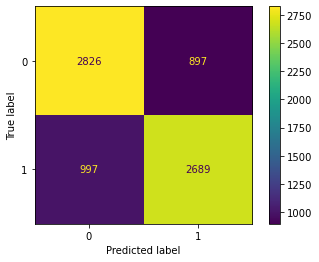

In [39]:
plot_confusion_matrix(gridsearch_non, X_train2, y_train2);

#### This model is much better than our first XGBC and is better overall than our Logistic Regression model too!  We're no longer overfit, and improved our scores accross the board.

We're going to follow up with another feature importance inspection.

In [13]:
boost_model_non = XGBClassifier(random_state=57, objective="reg:logistic",
                            learning_rate= 0.05, max_depth = 3, min_child_weight = 5,
                            n_estimators = 100, subsample = 0.6)
boost_model_non.fit(X_train2, y_train2)

features = list(zip(X_train2.columns, 100*(np.round(boost_model_non.feature_importances_, 4))))
features

[('blueFirstBlood', 1.25),
 ('blueDragons', 4.9),
 ('blueHeralds', 2.96),
 ('blueAvgLevel', 4.19),
 ('blueTotalExperience', 2.6499999),
 ('blueTotalJungleMinionsKilled', 2.8799999),
 ('blueGoldDiff', 32.41),
 ('blueExperienceDiff', 13.500001),
 ('blueGoldPerMin', 3.05),
 ('redDragons', 4.5),
 ('redHeralds', 3.6200001),
 ('redAvgLevel', 1.73),
 ('redTotalExperience', 2.76),
 ('redTotalJungleMinionsKilled', 1.9),
 ('redGoldPerMin', 3.81),
 ('bluePredWinrate', 4.4700003),
 ('redPredWinrate', 3.99),
 ('blueAvgPickrate', 2.6399999),
 ('redAvgPickrate', 2.78)]

## Modeling with new features 

Does either team have X impactful champion? (5 different champs)

In [15]:
new_df = pd.read_csv("../../../archive/with_rates_and_spec_gods.csv")
new_df.head()

gameId  blueWins  blueWardsPlaced  blueWardsDestroyed  blueFirstBlood  \
0  4519157822         0               28                   2               1   
1  4523371949         0               12                   1               0   
2  4521474530         0               15                   0               0   
3  4524384067         0               43                   1               0   
4  4436033771         0               75                   4               0   

   blueKills  blueAssists  blueDragons  blueHeralds  blueTowersDestroyed  \
0          9           11            0            0                    0   
1          5            5            0            0                    0   
2          7            4            1            0                    0   
3          4            5            0            1                    0   
4          6            6            0            0                    0   

   blueAvgLevel  blueTotalExperience  blueTotalJungleMinionsKilled  \
0           6.6                17039                            36   
1           6.6                16265                            43   
2           6.4                16221                            46   
3           7.0                17954                            55   
4           7.0                18543                            57   

   blueGoldDiff  blueExperienceDiff  blueCSPerMin  blueGoldPerMin  \
0           643                  -8          19.5          1721.0   
1         -2908               -1173          17.4          1471.2   
2         -1172               -1033          18.6          1611.3   
3         -1321                  -7          20.1          1515.7   
4         -1004                 230          21.0          1640.0   

   redWardsPlaced  redWardsDestroyed  redKills  redAssists  redDragons  \
0              15                  6         6           8           0   
1              12                  1         5           2           1   
2              15                  3        11          14           0   
3              15                  2         5          10           0   
4              17                  2         6           7           1   

   redHeralds  redTowersDestroyed  redAvgLevel  redTotalExperience  \
0           0                   0          6.8               17047   
1           1                   1          6.8               17438   
2           0                   0          6.8               17254   
3           0                   0          7.0               17961   
4           0                   0          7.0               18313   

   redTotalJungleMinionsKilled  redCSPerMin  redGoldPerMin  \
0                           55         19.7         1656.7   
1                           52         24.0         1762.0   
2                           28         20.3         1728.5   
3                           47         23.5         1647.8   
4                           67         22.5         1740.4   

                 blueChamps                 redChamps  bluePredWinrate  \
0    [111, 91, 236, 76, 54]    [26, 235, 82, 421, 69]         0.489394   
1    [4, 350, 75, 145, 875]    [110, 59, 53, 134, 39]         0.492787   
2    [421, 84, 236, 43, 45]  [145, 154, 92, 134, 223]         0.489751   
3  [64, 134, 516, 432, 429]  [110, 412, 58, 245, 238]         0.501475   
4  [101, 266, 245, 143, 21]     [51, 86, 69, 235, 32]         0.494971   

   redPredWinrate  blueAvgPickrate  redAvgPickrate  blueHas62  redHas62  \
0        0.509859         0.086790        0.103614      False     False   
1        0.492763         0.124203        0.121591      False     False   
2        0.498580         0.086608        0.112683      False     False   
3        0.508625         0.162425        0.144974      False     False   
4        0.511632         0.122280        0.077761      False     False   

   blueHas111  redHas111  blueHas145  redHas145  blueHas39  redHas39  \
0        True      False  

In [16]:
drop_col = ["blueWins", "gameId", "blueChamps", "redChamps"]
X_new = new_df.drop(drop_col, axis=1)
X_new = X_new.drop(nonimportant, axis=1)
y_new = new_df["blueWins"]

X_train_new, X_test_new, y_train_new, y_test_new = train_test_split(X_new, y_new, random_state=57)

boost_model_new = XGBClassifier(random_state=57, objective="reg:logistic",
                            learning_rate= 0.05, max_depth = 3, min_child_weight = 5,
                            n_estimators = 100, subsample = 0.6)
boost_model_new.fit(X_train_new, y_train_new)



print("Training Scores")
print(ScoreModel(boost_model_new, X_train_new, y_train_new))

print("Test Scores")
print(ScoreModel(boost_model_new, X_test_new, y_test_new))

Training Scores
Accuracy:   0.755027669051154
F1 Score:   0.7504468582428158
Recall:     0.740368963646229
Precision:  0.7608028993587956
ROC_AUC:    0.7549548283178767
None
Test Scores
Accuracy:   0.7404858299595142
F1 Score:   0.7378323108384457
Recall:     0.72508038585209
Precision:  0.7510407993338885
ROC_AUC:    0.7405989204953762
None


#### Here we have another decently performing model, however, we're still overfit to our training data.

Let's check out our feature importances again

In [17]:
features = list(zip(X_train_new.columns, 100*(np.round(boost_model_new.feature_importances_, 4))))
features

[('blueFirstBlood', 1.3199999),
 ('blueDragons', 3.74),
 ('blueHeralds', 1.8),
 ('blueAvgLevel', 2.83),
 ('blueTotalExperience', 2.3),
 ('blueTotalJungleMinionsKilled', 1.97),
 ('blueGoldDiff', 25.78),
 ('blueExperienceDiff', 10.31),
 ('blueGoldPerMin', 2.33),
 ('redDragons', 4.1499996),
 ('redHeralds', 3.52),
 ('redAvgLevel', 1.99),
 ('redTotalExperience', 2.34),
 ('redTotalJungleMinionsKilled', 1.23),
 ('redGoldPerMin', 2.8200002),
 ('bluePredWinrate', 3.39),
 ('redPredWinrate', 3.04),
 ('blueAvgPickrate', 2.04),
 ('redAvgPickrate', 2.19),
 ('blueHas62', 0.0),
 ('redHas62', 2.53),
 ('blueHas111', 2.38),
 ('redHas111', 2.17),
 ('blueHas145', 2.84),
 ('redHas145', 2.09),
 ('blueHas39', 2.87),
 ('redHas39', 3.34),
 ('blueHas517', 1.26),
 ('redHas517', 1.4499999)]

In [18]:
IPython.display.Audio(sound_file, autoplay=True, rate=1000)

## Summary

It seems that the first 10 minutes of a game are significantly impactful on the outcome of a match.  My models are consistently producing above a 70% accuracy score, with my best model at 74%.

Even though the first 10 minutes are impactful, our results are only 24% better than random guessing (which would be 50%).  I attribute this to the fact that game time averages around 30 minutes, so there's still plenty of time for the disadvantaged team to make a comeback, and in some rare cases the winning team is still at a disadvantage in terms of overall statistics.  If we were take data from less skilled players, we could expect this variability in wins to be more apparent.

As far as features that are driving our model, team gold and experience leads are the most important, with a couple features like dragons and the average winrate of a team's selected champions being less important, but not something that's necessarily correlated with gold and experience leads.  In the case of dragons, they provide team wide buffs that aren't measured in terms of gold or experience (though killing the dragon awards a small amount of gold and xp).

## Visuals for presentation

Weight. The number of times a feature is used to split the data across all trees.

Cover. The number of times a feature is used to split the data across all trees weighted
        by the number of training data points that go through those splits.
        
Gain. The average training loss reduction gained when using a feature for splitting.

Text(0.5, 1.0, 'Feature Importance - Weight')

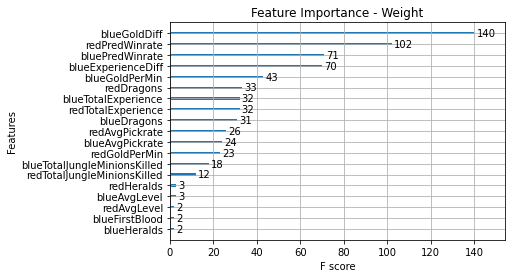

In [27]:
xgboost.plot_importance(boost_model_non)
plt.title("Feature Importance - Weight")

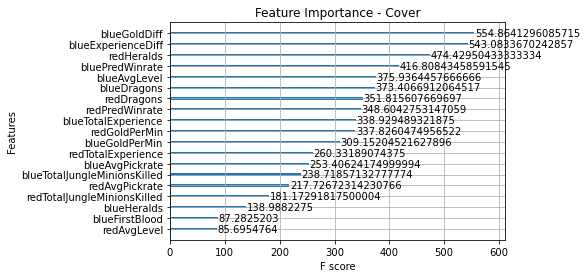

In [28]:
xgboost.plot_importance(boost_model_non, importance_type="cover")
plt.title("Feature Importance - Cover");

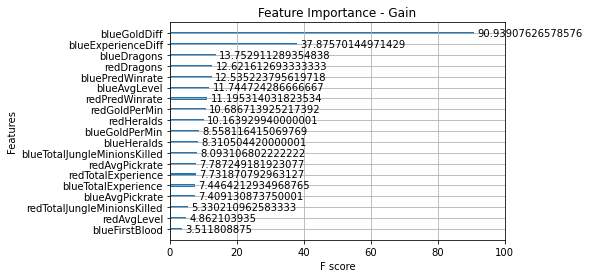

In [29]:
xgboost.plot_importance(boost_model_non, importance_type="gain")
plt.title("Feature Importance - Gain");

#### Found a neat visualization tool called SHAP that uses Shapley Values to interpret machine learning models, and has built in support for XGBoost

In [31]:
import shap
shap.initjs()

explainer = shap.TreeExplainer(boost_model_non)
shap_values = explainer.shap_values(X_train2)

shap.force_plot(explainer.expected_value, shap_values[0,:], X_train2.iloc[0,:])

In [32]:
shap.force_plot(explainer.expected_value, shap_values[:1000,:], X_train2.iloc[:1000,:])

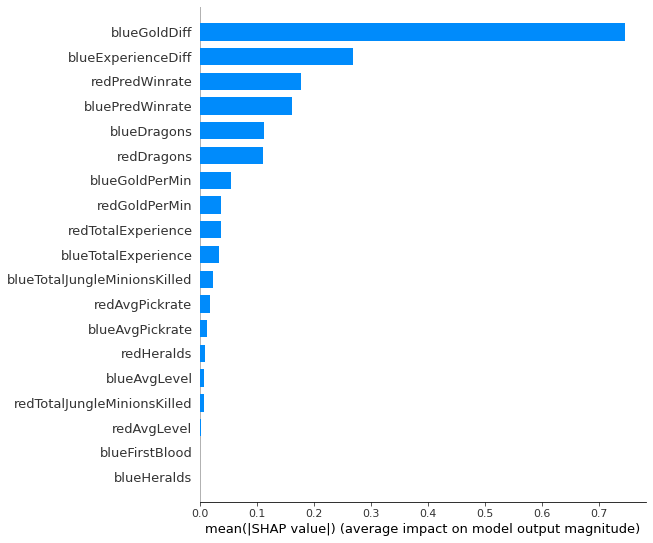

In [33]:
shap.summary_plot(shap_values, X_train2, plot_type="bar")

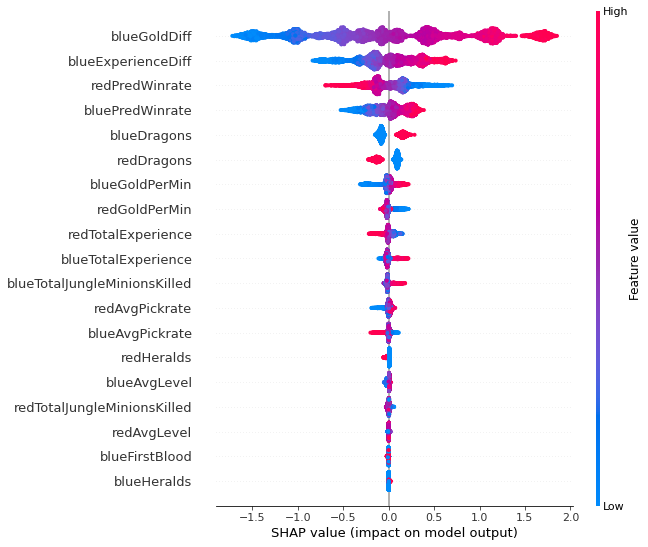

In [35]:
shap.summary_plot(shap_values, X_train2)

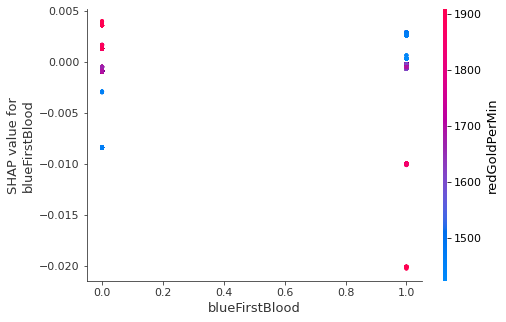

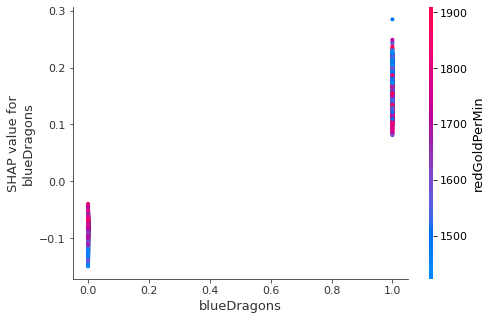

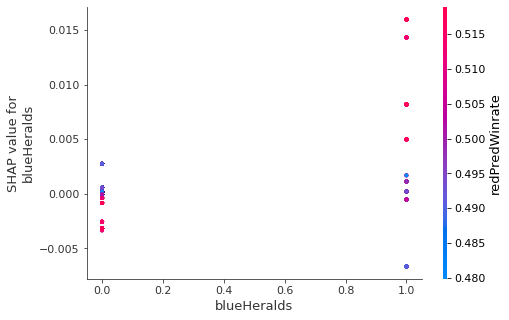

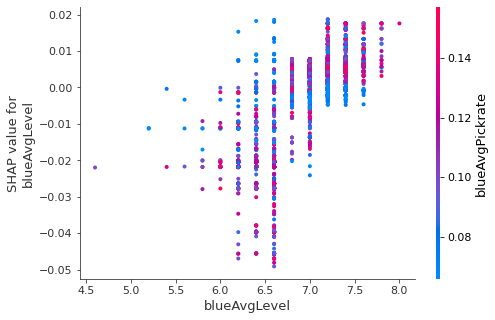

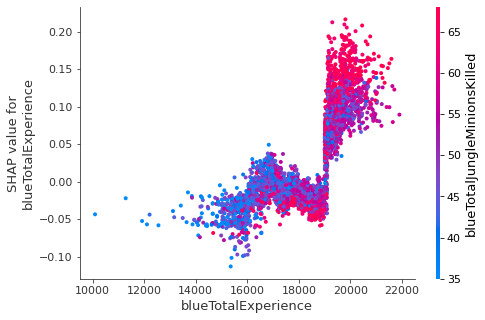

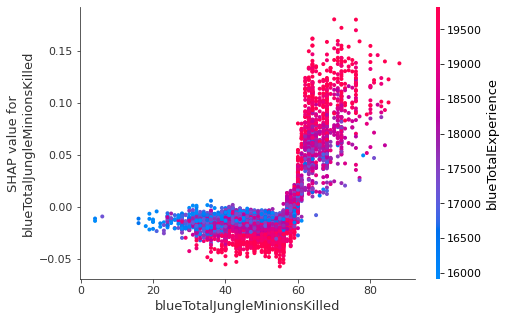

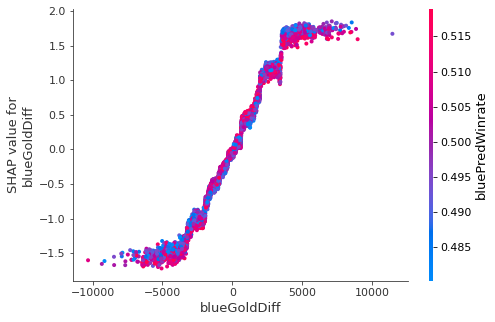

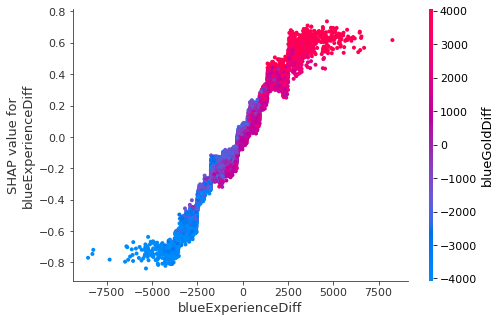

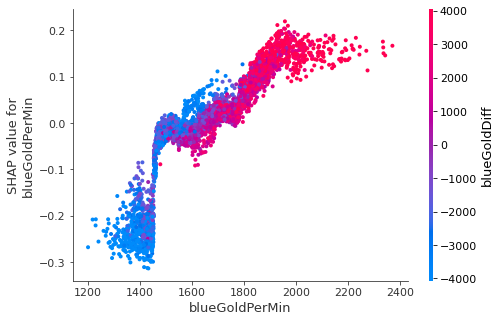

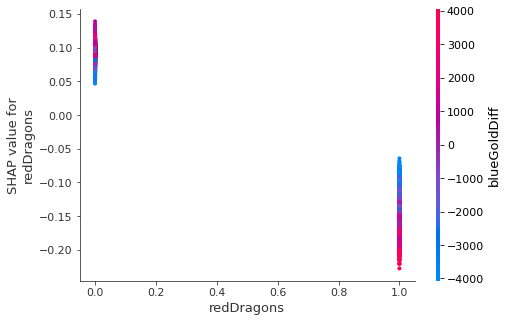

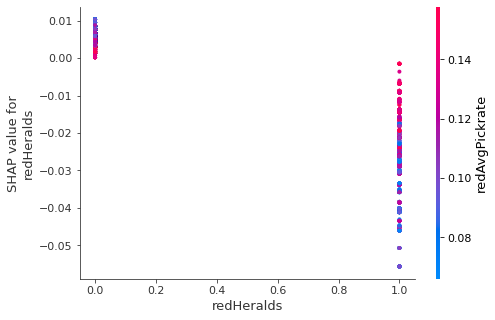

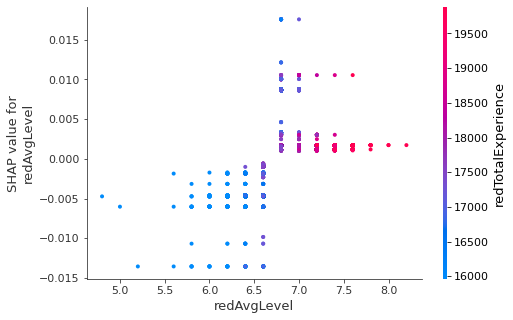

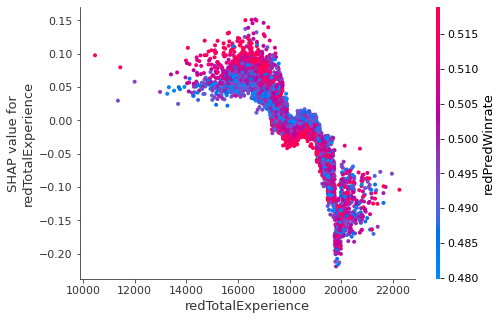

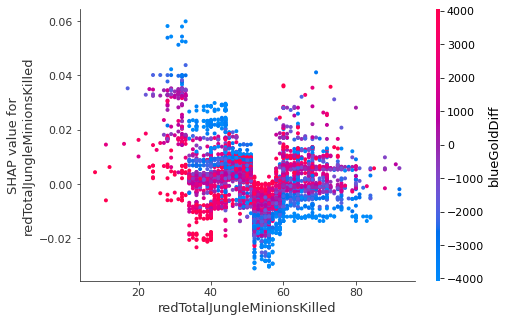

Passing parameters norm and vmin/vmax simultaneously is deprecated since 3.3 and will become an error two minor releases later. Please pass vmin/vmax directly to the norm when creating it.


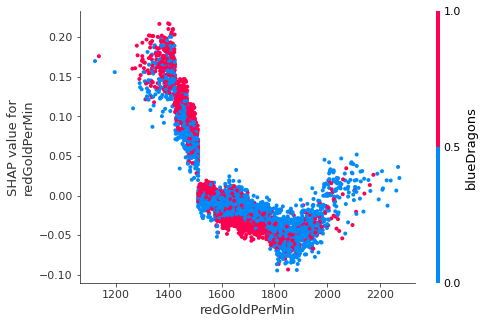

Passing parameters norm and vmin/vmax simultaneously is deprecated since 3.3 and will become an error two minor releases later. Please pass vmin/vmax directly to the norm when creating it.


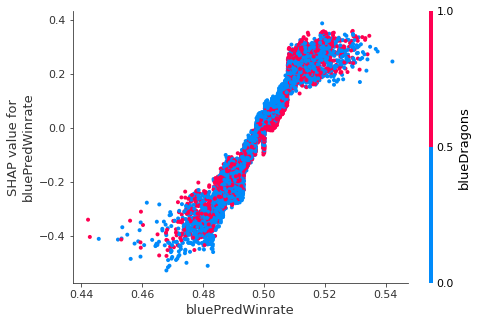

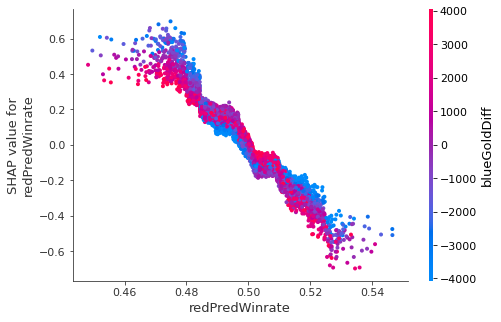

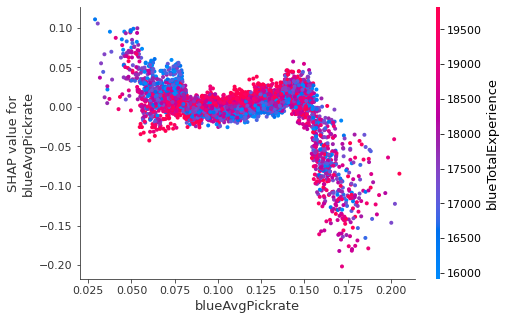

Passing parameters norm and vmin/vmax simultaneously is deprecated since 3.3 and will become an error two minor releases later. Please pass vmin/vmax directly to the norm when creating it.


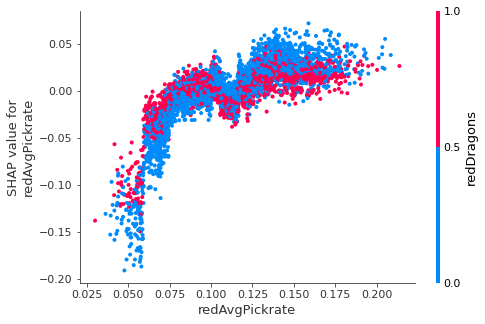

In [37]:
for name in X_train2.columns:
    shap.dependence_plot(name, shap_values, X_train2, display_features=X_train2)